In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy.ndimage import gaussian_filter
BINS = 70

def occupancy_map(tracking = None, binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    occupancy = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    data_points = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(len(xpos))]
    ynew = [int(ypos[i]/xdenom) for i in range(len(xpos))]
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neuronID = 0):
     
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    x = np.array([int(tracking[0,i]) for i in range(tracking.shape[1])])
    y = np.array([int(tracking[1,i]) for i in range(tracking.shape[1])])
    xpos = x[np.logical_and(x>0,y>0)]
    ypos = y[np.logical_and(x>0,y>0)]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    counter = 0
    for x,y in zip(xpos,ypos):
        if x>0 and y>0:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map

def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    return index




In [110]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32363       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 2
period = int(5 * sf / re_sf)
period_resting = period *50
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            

In [111]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/trial_aligned_events/'


In [154]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
corners_list = []
speed_list = []

behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0

print('LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR')
for trial in [1,6,11,16]:

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_corners.npy'
    ## LOAD CORNERS EXPLORATION
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    corners = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])

    speed_file_name = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_speed.npy'
    ## LOAD INSTANTANEOUS SPEED
    speed = np.load(behaviour_dir + speed_file_name)
    reshape_speed = np.reshape(speed[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_speed = np.reshape(scipy.stats.mode(reshape_speed,axis=1)[0],reshape_speed.shape[0])
    
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        r_params = parameters[param,:resample_speed.shape[0]]
        r_params[:r2_params.shape[0]] = r2_params
        params.append(r_params)
    resample_params = np.array(params)
    print(resample_params.shape)
    
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                            re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)

    behaviour_list.append(resample_beh1)
    corners_list.append(corners)
    speed_list.append(resample_speed)

    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]


    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                            '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

     ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1[:,:int(int(behaviour.shape[0]/re_sf)*re_sf)]
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                            re_sf=re_sf)

    activity_list.append(resample_neural_activity_mean)
    print(resample_neural_activity_mean.shape)

    day = day + 1
 

LOADING TRIALS ACTIVITY AND CREATING LIST OF ACTIVITY, TRACKING AND BEHAVIOUR
(13, 37457)
(90, 37457)
(13, 36983)
(35, 36983)
(13, 35889)
(26, 35889)
(13, 36073)
(25, 36073)


In [146]:
day = 0
pca = PCA()
activity_list_pca = []
variance_list = []
variance_ratio_list = []

cca_components = min(13,activity_list[day].shape[0])
cca = CCA(n_components=cca_components)
activity_list_cca = []

for day in range(len(behaviour_list)):
    ### run pca on the entire 
    pca.fit(activity_list[day].T)
    transformed_activity = pca.fit(activity_list[day].T).transform(activity_list[day].T)
    activity_list_pca.append(transformed_activity.T)
    variance_list.append(pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2)
    normalized_variance = pca.explained_variance_/(1+np.sqrt(activity_list[day].shape[0]/activity_list[day].shape[1]))**2
    variance_ratio_list.append(np.cumsum(normalized_variance/sum(normalized_variance)))
    activity_list_cca.append(cca.fit(activity_list[day].T, parameters_list[day].T).transform(activity_list[day].T))
    

In [155]:
    ## define targets of behaviour according to protocol (random, overlapping and stable)

    id_target = [0,1,2,3,4] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2
    
    print('REDIFINING BEHAVIOUR FOR DIFFERENT SESSIONS')

    if colapse_behaviour == 0 : # RANDOM
        for day in range(len(behaviour_list)):
            for trial in range(5):
                behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
                objects = np.unique(behaviour_trial)
                selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
                index0 = np.where(behaviour_trial==objects[selected_object])[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))[0]
                behaviour_trial[index0] = 3
                behaviour_trial[index1] = 4

                behaviour_trial[index2] = 4            

                index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
                index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))[0]
                index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))[0]
                behaviour_trial[index0] = 0
                behaviour_trial[index1] = 0
                behaviour_trial[index2] = 0 

                behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


    if colapse_behaviour == 1 : #OVERLAPPING
        for day in range(len(behaviour_list)):
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
            behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
            behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 0        
            behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 0
            behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 0


    if colapse_behaviour == 2: #STABLE
        for day in range(len(behaviour_list)):
            objects = np.unique(behaviour_list[day])
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
            behaviour_list[day][index0] = 3
            behaviour_list[day][index1] = 4
            behaviour_list[day][index2] = 4      

            index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
            behaviour_list[day][index0] = 0
            behaviour_list[day][index1] = 0
            behaviour_list[day][index2] = 0  

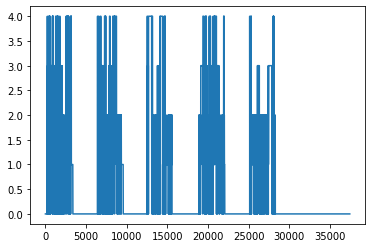

In [156]:
navigation_list = [] 
exploration_list = []

SPEED_LIMIT = 5
for day in range(4):
    speed = signal.medfilt(speed_list[day],9)
    # select the corners that are being explored when the animal is doing an exploratory task
    navigation = np.zeros_like(corners_list[day])
    navigation[np.where(behaviour_list[day]==4)[0]] = corners_list[day][np.where(behaviour_list[day]==4)[0]]
    navigation[np.where(behaviour_list[day]==3)[0]] = corners_list[day][np.where(behaviour_list[day]==3)[0]]
    exploration_corner = np.zeros_like(navigation)
    # create a vector that contains zeros everywhere but object ID number when the animal is exploring an object a particular corner with low speed
    exploration_corner[np.where(speed<SPEED_LIMIT)[0]] = navigation[np.where(speed<SPEED_LIMIT)[0]]
    
    navigation_corner = np.zeros_like(navigation)
    for corner in [1,2,3,4]:
        # create a vector that contains zeros everywhere but corner ID when the animal is navigation at that position with out an object
        navigations_at_corner = np.logical_and(exploration_corner==0,corners_list[day]==corner)
        navigation_corner[np.logical_and(navigations_at_corner, speed < SPEED_LIMIT)] = corner
        
    navigation_list.append(navigation_corner)
    exploration_list.append(exploration_corner)

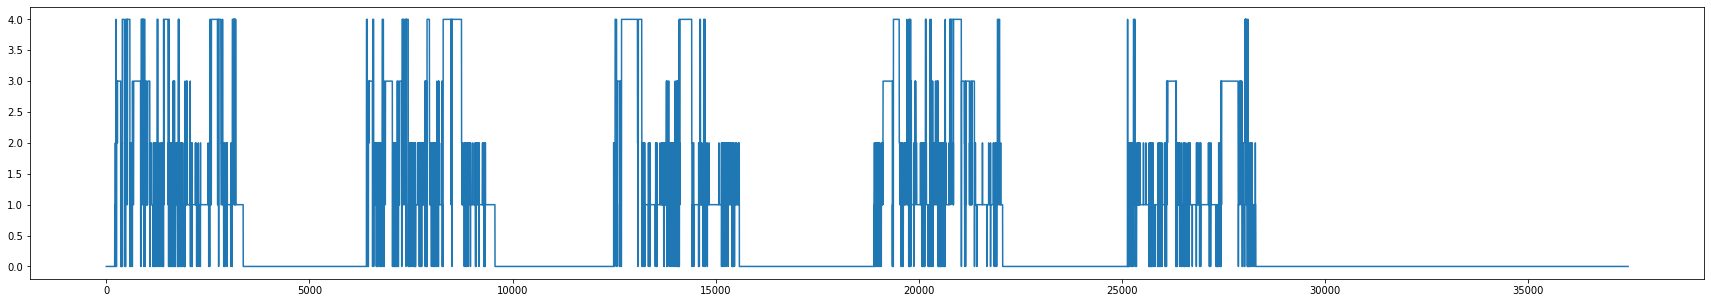

In [160]:
figure, axes = plt.subplots()

plt.plot(behaviour_list[0])
#axes.plot(corners_list[0])

#axes.plot(navigation_list[0])
#axes.plot(exploration_list[0])

#axes.set_xlim([0,5000])

figure.set_size_inches(30,5)

In [132]:
# for each day creates a list that counts and saves times of different events.
events_day_list_1 = []
events_day_list_shuffle_1 = []

events_counter_day_list = []
events_time_starts_day = []

for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    random_events = []
    start_counter = 100
    counter = 0
    #for i in range(exploration_list[day].shape[0]):
    for i in range(navigation_list[day].shape[0]):
        #if exploration_list[day][i] != start_counter:
        if navigation_list[day][i] != start_counter:
            events_list.append(start_counter) # contains a sequence of events ID
            events_counter_list.append(counter) # conteins the duration of each event
            events_time_starts.append(i) # contains the time at which event starts
            #start_counter = behaviour_list[day][i] 
            #start_counter = exploration_list[day][i]
            start_counter = navigation_list[day][i]

            counter = 1
        else:
            counter = counter + 1    
            
    events_day_list_1.append(events_list)
    shufflings = []
    for j in range(10):
        shufflings.append(events_list.copy())
    events_day_list_shuffle_1.append(shufflings)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [133]:
## compute events duration for type of event. Here we create lists that we can access to know the duration of each ID event
## we will use this to balance the dataset
selection_target = [1,2,3,4]    # here we balcance the data only for this targets of behaviour

events_duration_list = []
total_duration_list = []

for day in range(len(behaviour_list)):
    events_duration_day = []
    total_duration_day = []
    for target in selection_target:
        events = np.array(events_day_list_1[day])  # all events in a day
        events_counter = np.array(events_counter_day_list[day]) #duration of all day events
        events_time = np.array(events_time_starts_day[day]) # start time of events in day
        
        position_events = np.where(events == target)[0] # select events related to one specific ID
        events_duration_target = events_counter[position_events]   # take the duration of the events for that ID
        events_duration_day.append(events_duration_target)
        
        total_duration_day.append(np.sum(events_duration_target))
    events_duration_list.append(events_duration_day)
    total_duration_list.append(total_duration_day)
    

In [134]:
### Balancing the number of events for selected targets ...

In [135]:
## put all events together and take neural activity from each event
events_activity= []
events_duration_list = []
events_activity_pca = []
events_activity_cca = []


for day in range(len(behaviour_list)):
    print('day:'  + f'{day}')
    target_activity = []
    target_activity_pca = []
    target_activity_cca = []
    events_duration_day = []
    
    events = np.array(events_day_list_1[day])
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])

    for target in selection_target:
        all_events = np.where(events == target)[0]
        #print('target:' + f'{target}')
        #print(len(all_events))
        if len(all_events):
            position_events = all_events#[events_day_list[day][target]]

            events_duration = events_counter[position_events]   # convert to seconds
            time = events_time[position_events]
            i = 0
            event_target = []
            event_target_pca = []
            event_target_cca = []
            #events_duration_target = np.zeros(len(events_duration),)
            events_duration_target = []
            for event in events_duration:
                #print(event)
                if event > 0:
                    local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                    local_activity_pca = activity_list_pca[day][:,time[i]-period:time[i]+period]
                    local_activity_cca = activity_list_cca[day][time[i]-period:time[i]+period,:].T
                    event_target.append(local_activity)
                    event_target_pca.append(local_activity_pca)
                    event_target_cca.append(local_activity_cca)
                    #events_duration_target[i]=1
                    events_duration_target.append(events_duration[i])
                i = i + 1
        #print(len(event_target))
        target_activity.append(event_target)
        target_activity_pca.append(event_target_pca)
        target_activity_cca.append(event_target_cca)
        events_duration_day.append(events_duration_target)
    events_activity.append(target_activity)
    events_duration_list.append(events_duration_day)
    events_activity_pca.append(target_activity_pca)
    events_activity_cca.append(target_activity_cca)

day:0
day:1
day:2
day:3


44
target0
68
target1
41
target2
50
target3


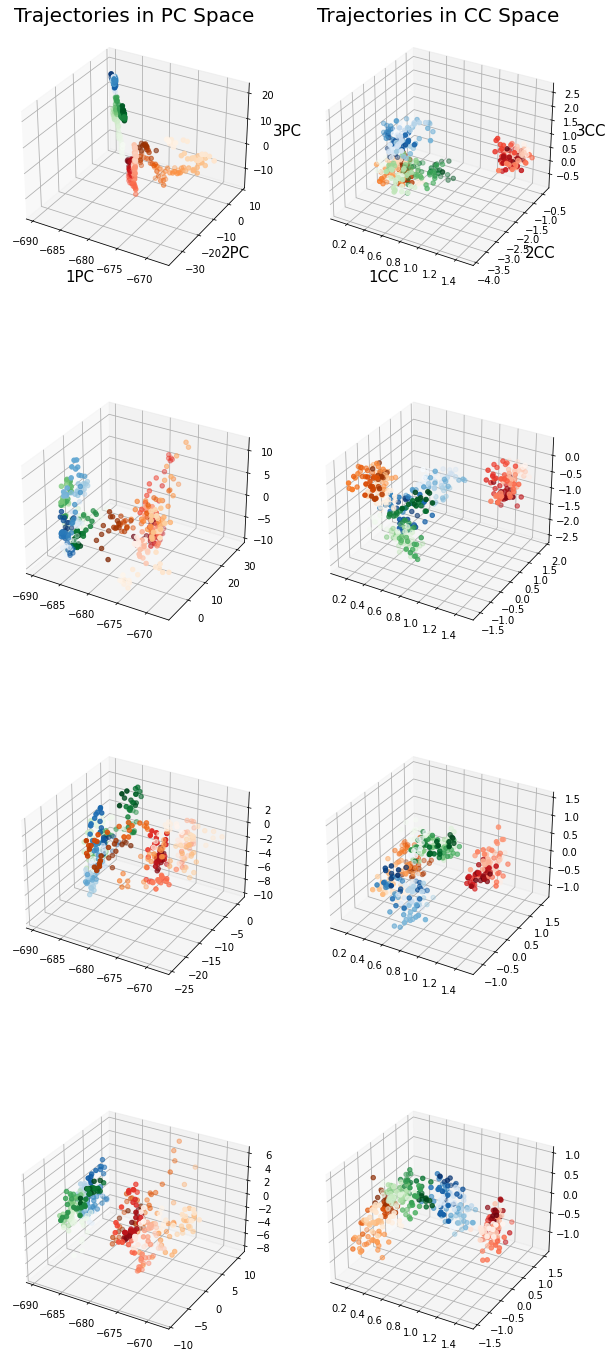

In [136]:
day = 0
figure = plt.figure()
gs = plt.GridSpec(4, 2)

color_code = ['Reds','Blues','Oranges','Greens']
    
axes_pc_trajectory0 = figure.add_subplot(gs[0,0],projection = '3d')
axes_pc_trajectory1 = figure.add_subplot(gs[1,0],projection = '3d')
axes_pc_trajectory2 = figure.add_subplot(gs[2,0],projection = '3d')
axes_pc_trajectory3 = figure.add_subplot(gs[3,0],projection = '3d')

axes_pc_trajectory0.set_title('Trajectories in PC Space', fontsize = 20)
axes_pc_trajectory0.set_xlabel('1PC',fontsize = 15)
axes_pc_trajectory0.set_ylabel('2PC',fontsize = 15)
axes_pc_trajectory0.set_zlabel('3PC',fontsize = 15)
# axes_pc_trajectory.set_xlim([-4,-2])
# axes_pc_trajectory.set_ylim([-4,-2])
# axes_pc_trajectory.set_zlim([-1,1])

axes_cc_trajectory0 = figure.add_subplot(gs[0,1],projection = '3d')
axes_cc_trajectory1 = figure.add_subplot(gs[1,1],projection = '3d')
axes_cc_trajectory2 = figure.add_subplot(gs[2,1],projection = '3d')
axes_cc_trajectory3 = figure.add_subplot(gs[3,1],projection = '3d')
axes_cc_trajectory0.set_title('Trajectories in CC Space', fontsize = 20)
axes_cc_trajectory0.set_xlabel('1CC',fontsize = 15)
axes_cc_trajectory0.set_ylabel('2CC',fontsize = 15)
axes_cc_trajectory0.set_zlabel('3CC',fontsize = 15)
# axes_cc_trajectory.set_xlim([-7,-3])
# axes_cc_trajectory.set_ylim([-2,-0])
# axes_cc_trajectory.set_zlim([2,3]) 
    
j=0 
for target in range(4):
    print(len(events_activity[day][target]))
    # real data! 
    print('target' + str(target))
    if events_activity[day][target] != []:
        trial_activity = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_complete = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*10+1))
        trial_activity_all_data = np.zeros((events_activity[day][target][0].shape[0],len(events_activity[day][target])*2*period+1))
        trial_activity_pca = np.zeros((events_activity[day][target][0].shape[0],events_activity[day][target][0].shape[1]))
        trial_activity_cca = np.zeros((cca_components,events_activity[day][target][0].shape[1]))

        ### generate matrix with mean activity and entire trial repetitions activity
        for neuron in range(events_activity[day][target][0].shape[0]):
            neuron_trial_activity = np.zeros((events_activity[day][target][1].shape[1],))
            component_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            cca_trial_activity = np.zeros((events_activity[day][target][0].shape[1],))
            init = 0
            init2=0
            for trial in range(len(events_activity[day][target])):
                if len(events_activity[day][target][trial][neuron,:]):
                    #print(events_activity[day][target][trial][neuron,:].shape)
                    neuron_trial_activity += events_activity[day][target][trial][neuron,:]#/(np.max(events_activity[day][target][trial][neuron,:])-np.min(events_activity[day][target][trial][neuron,:]))
                    component_trial_activity +=events_activity_pca[day][target][trial][neuron,:]
                    if neuron < cca_components:
                        cca_trial_activity +=events_activity_cca[day][target][trial][neuron,:]
                    trial_activity_all_data[neuron,init2:init2+2*period]= events_activity[day][target][trial][neuron,:]
                    trial_activity_complete[neuron,init:init+10] = events_activity[day][target][trial][neuron,period:period+10]
                    init = init+10
                    init2=init2+2*period
            neuron_trial_activity = neuron_trial_activity / len(events_activity[day][target])
            component_trial_activity = component_trial_activity / len(events_activity[day][target])
            trial_activity[neuron,:] = neuron_trial_activity
            trial_activity_pca[neuron,:] = component_trial_activity
            if neuron < cca_components:
                trial_activity_cca[neuron,:] = cca_trial_activity / cca_components
        color = np.linspace(0, 20, 2*period)
        
        axes_pc_trajectory0.scatter(trial_activity_pca[0,:],trial_activity_pca[1,:],trial_activity_pca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        axes_cc_trajectory0.scatter(trial_activity_cca[0,:],trial_activity_cca[1,:],trial_activity_cca[2,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        
        axes_pc_trajectory1.scatter(trial_activity_pca[0,:],trial_activity_pca[4,:],trial_activity_pca[5,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        axes_cc_trajectory1.scatter(trial_activity_cca[0,:],trial_activity_cca[4,:],trial_activity_cca[5,:], c = color, cmap = color_code[j], marker = 'o', s = 20)

        axes_pc_trajectory2.scatter(trial_activity_pca[0,:],trial_activity_pca[6,:],trial_activity_pca[7,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        axes_cc_trajectory2.scatter(trial_activity_cca[0,:],trial_activity_cca[6,:],trial_activity_cca[7,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        
        axes_pc_trajectory3.scatter(trial_activity_pca[0,:],trial_activity_pca[8,:],trial_activity_pca[9,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        axes_cc_trajectory3.scatter(trial_activity_cca[0,:],trial_activity_cca[8,:],trial_activity_cca[9,:], c = color, cmap = color_code[j], marker = 'o', s = 20)
        j = j + 1

figure.set_size_inches(10,25)
figure.savefig(figure_path + 'mouse_'+f'{mouse}'+'_session_'+f'{session}'+ '_navigation.png')

In [131]:
figure_path

'/home/melisa/Documents/neural_analysis/figures/trial_aligned_events/'